## Setting Up the Libs and Overthrust Configurations

In [1]:
#### from __future__ import print_function
import time
import torch
import torch.nn as nn
import numpy as np
import scipy.ndimage
import matplotlib
#matplotlib.use('Agg')
import matplotlib.pyplot as plt
import deepwave
import os
from timeit import default_timer as timer
import scipy.io as spio
import math
import numpy as np
from utils.utils import *
from torch import optim
from IPython.core.debugger import set_trace 
import random
torch.manual_seed(0)
random.seed(0)

####################################################
####   MAIN PARAMETERS FOR FORWARD MODELING         ####
####################################################

peak_freq = 5.                    # central frequency
peak_source_time = 1 / peak_freq  # the time (in secs) of the peak amplitude
dx        = 30.0                  # step interval along x/z direction
dx1        = 30.0                  # step interval along y/z direction

dt        = 0.003                 # time interval (e.g., 3ms)
num_dims  = 2                     # dimension of velocity model
nz        = 94                   # model shape of z dimension (depth) Overthurst
ny        = 400                   # model shape of y dimension Overthurst
vmodel_dim = np.array([nz, ny])

total_t   = 6.                      # totle sampling time (unit: s)
nt        = int(total_t / dt)       # number of time sampling points
num_shots = 6                      # nunmber of shots
num_sources_per_shot =  5           # number of sources per 
num_shotsall = num_shots * num_sources_per_shot
num_receivers_per_shot = 400        # number of receivers per shot
source_spacing = np.floor(dx * ny / (num_shotsall+1))                         # space intervel between neigbouring sources
receiver_spacing = np.floor(dx * ny / (num_receivers_per_shot +1))         # space intervel between neigbouring receivers
source_depth = 0                # the index depth of sources, default is 0
receiver_depth = 0              # the index depths of receivers, default is 0
order          = 8              # precision order of finite difference in space domain
pml_width  = [0,10,10,10,0,0]   # pml padding width for boundary (0 for free surface and 10 for absorbing boundary)

#fwi_lr            = 20        # learning rate for updating the model.
fwi_lr =100
fwi_batch         =   num_shots      # number of batches for FWI.
fwi_num_epochs    = 600       # number of FWI iteration.
#sim_lr           = 1*1e-5    # learning rate for Soamese network.
sim_lr = 1e-9
survey_pad = None
savepoch = 50                 # Saving models each 50 FWI iterations


/home/sadalyom/.conda/envs/FWIGAN/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


##   Check Cuda Device 


In [2]:
torch.backends.cudnn.enabled = True
torch.backends.cudnn.benchmark = True

cuda_available = torch.cuda.is_available()
device = torch.device("cuda" if cuda_available else "cpu")
device

device(type='cuda')

## Sorting sources randomly

In [3]:

 '''
indx = []
for i in range (num_shots):
    indx.append(np.arange(i,num_shotsall,num_shots))
indx = (np.array(indx)).flatten()
'''
np.random.seed(420098643)
indx = np.random.permutation(num_shotsall)

indx

array([ 0, 18, 27, 12, 16, 24,  8,  7, 14,  9,  3,  6, 13, 22, 20,  1,  4,
        2, 29, 10, 25, 17, 21, 11, 28, 15, 23, 26, 19,  5])

In [4]:
 
data_path = 'data/over_94_400.bin'
initfile = 'data/over_initmodel.mat'
initsafile = 'data/over_initsource.mat'
fwi_result = 'results/overthrustmsfwi/'


# Loading the true model
model_true = loadtruemodel(data_path, num_dims, vmodel_dim).to(device)
model, model_init = loadinitmodel(initfile,device)
model, model_init = createInitialModel(model_true, 'GS', 25, 0, device)

# The model will be updated during FWI
model = torch.nn.Parameter(model)
# Creating source and reciver locations
_, x_r = createSR(num_shots, num_sources_per_shot, num_receivers_per_shot, num_dims, source_spacing, receiver_spacing,source_depth,receiver_depth)
x_s, _ = createSR(num_shotsall, 1, num_receivers_per_shot, num_dims, source_spacing, receiver_spacing,source_depth,receiver_depth)
x_s = x_s[indx]
x_s = x_s.reshape(num_shots, num_sources_per_shot,2)
x_s, x_r = x_s.to(device), x_r.to(device)
# Source Amplitude
source_amplitudes_init, source_amplitudes_true = loadinitsource(initsafile,device)
source = source_amplitudes_init.repeat(1,num_shots, num_sources_per_shot)
# receiver Amplitude
receiver_amplitudes = createdata(model_true,dx,source, \
                                x_s,x_r,dt,pml_width,order, \
                                 survey_pad,device).to(device)
receiver_amplitudes_true = receiver_amplitudes
rcv_amps_true = receiver_amplitudes_true.clone()

model size: torch.Size([94, 400])


## Plotting the inital and true model


findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


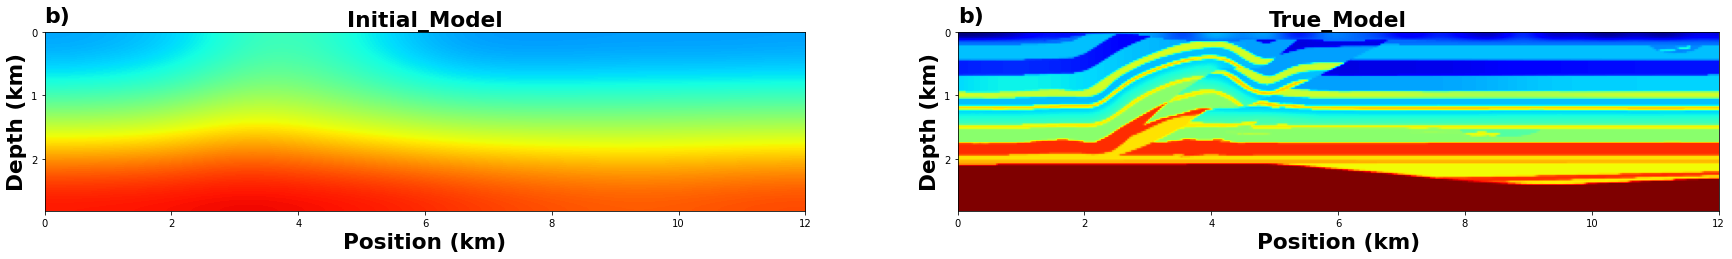

In [5]:
from matplotlib.ticker import MaxNLocator
import matplotlib.pyplot as plt
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 18}

y = np.array([0, 1, 2, 3])
box_min = 2360
box_max = 6000

f, ax = plt.subplots(1,2,figsize=(30, 13))
plt.rc('font', **font)


im = ax[0].imshow(model_init, cmap='jet', vmin=box_min, vmax=box_max, 
                extent=[0, model_init.shape[1] * dx / 1000, model_init.shape[0] * dx1 / 1000, 0])
ax[0].set_xlabel('Position (km)',fontsize='large', fontweight='bold')
ax[0].set_ylabel('Depth (km)',fontsize='large', fontweight='bold')
ax[0].set_title('Initial_Model',fontsize='large', fontweight='bold')
ax[0].text(0, -0.15, 'b)', fontsize = 22) 
ax[0].xaxis.set_major_locator(MaxNLocator(integer=True))
ax[0].set_yticks(np.arange(y.min(), y.max(), 1)) 

model1 = model_true.detach().cpu().numpy()
im = ax[1].imshow(model1, cmap='jet', vmin=box_min, vmax=box_max, 
                extent=[0, model1.shape[1] * dx / 1000, model1.shape[0] * dx1 / 1000, 0])
ax[1].set_xlabel('Position (km)',fontsize='large', fontweight='bold')
ax[1].set_ylabel('Depth (km)',fontsize='large', fontweight='bold')
ax[1].set_title('True_Model',fontsize='large', fontweight='bold')
ax[1].text(0, -0.15, 'b)', fontsize = 22) 
ax[1].xaxis.set_major_locator(MaxNLocator(integer=True))
ax[1].set_yticks(np.arange(y.min(), y.max(), 1)) 


plt.show()

## Setting Up the Siamese and Optimizers

In [6]:
from torchsummary import summary
from Model.Module22_6 import *
import  torch


#Learning Schedule
def lr_lambda(epoch):
    return 1/2

#Learning Schedule
def lr_lambda1(epoch):
    return 1/2

### optimizer for the velocity model
optimizer = optim.Adam([{'params': model, 'lr':fwi_lr, 'betas':(0.5, 0.9), 'eps':1e-6,
                          'weight_decay':0}])

#Best
#leak_value = 0.0001
leak_value = 0.00001
D1 = 1
netD = SiameseNetwork(D1)
### init the hyper-parameters of netD ###
netD = netD.apply(lambda m: weights_init(m, leak_value))
netD = netD.to(device)


# Optimizer for Siamese network.
optim_s = optim.Adam(netD.parameters(),lr=sim_lr,betas=(0.5, 0.99), \
                    eps=1e-6, weight_decay=0)

scheduler = torch.optim.lr_scheduler.MultiplicativeLR(optimizer, lr_lambda=lr_lambda)
scheduler1 = torch.optim.lr_scheduler.MultiplicativeLR(optim_s, lr_lambda=lr_lambda1)

"""Compute number of parameters"""
s  = sum(np.prod(list(p.size())) for p in netD.parameters())
print ('Number of netD params: %d' % s)

#summary(netD,[(nt,1,num_receivers_per_shot),(nt,1,num_receivers_per_shot)])


############## Init  ################# 
SNR = 0.0
SSIM = 0.0
Loss = 0.0
ERROR = 0.0




Number of netD params: 1519


## Main SiameseFWI

In [7]:
 
import torch.nn.functional as F
# Starting the FWI loop.
global model_true, source_amplitudes_init, SNR, SSIM, Loss, ERROR
import torch.fft






t_start = time.time()
model_true = model_true.view(nz,ny)
# number of shots per batch
num_shots_per_batch = int(num_shots / fwi_batch) 
criterion = nn.MSELoss()
for i in range(fwi_num_epochs):
    # initialization of the loss
    epoch_loss = 0.0

    for it in range(fwi_batch):
        iteration = i*fwi_batch+it+1
        # Set both optimizers to zero grad.
        optimizer.zero_grad()
        netD.train()                
        netD.zero_grad() 
        
        # Forward modeling based on AWE (DeepWave).
        prop = deepwave.scalar.Propagator({'vp': model},dx,pml_width, \
                                          order,survey_pad)
        batch_src_amps = source_amplitudes_init.repeat(1, num_shots_per_batch, num_sources_per_shot)
        batch_rcv_amps_true= rcv_amps_true[:,it::fwi_batch].to(device)
        batch_x_s = x_s[it::fwi_batch].to(device)
        batch_x_r = x_r[it::fwi_batch].to(device)
        batch_rcv_amps_pred= prop(batch_src_amps, batch_x_s, batch_x_r, dt)

        
        # R, A, and I
        d_real = batch_rcv_amps_true[:,0,:]
        d_real_f = torch.fft.fft(d_real, dim=0)
        d_abs = torch.abs(d_real_f)
        d_abs = torch.cat([d_abs[0:400,:],d_abs[-400:,:]])
        #d_abs = d_abs.permute(1,0)
        d_abs = d_abs.unsqueeze(0).unsqueeze(0)
        
        d_real_r = torch.real(d_real_f)
        d_real_r = torch.cat([d_real_r[0:400,:],d_real_r[-400:,:]])
        #d_real_r = d_real_r.permute(1,0)
        d_real_r = d_real_r.unsqueeze(0).unsqueeze(0)
        
        d_real_i = torch.imag(d_real_f)
        d_real_i = torch.cat([d_real_i[0:400,:],d_real_i[-400:,:]])
        #d_real_i = d_real_i.permute(1,0)
        d_real_i = d_real_i.unsqueeze(0).unsqueeze(0)
        d_real_inp = torch.cat([d_real_r,d_real_i,d_abs],axis=1)


        d_fake = batch_rcv_amps_pred[:,0,:]       
        d_fake_f = torch.fft.fft(d_fake, dim=0)
        d_abs_f = torch.abs(d_fake_f)
        d_abs_f = torch.cat([d_abs_f[0:400,:],d_abs_f[-400:,:]])
        #d_abs_f = d_abs_f.permute(1,0)
        d_abs_f = d_abs_f.unsqueeze(0).unsqueeze(0)
        
        d_fake_r = (torch.real(d_fake_f))
        d_fake_r = torch.cat([d_fake_r[0:400,:],d_fake_r[-400:,:]])
        #d_fake_r = d_fake_r.permute(1,0)
        d_fake_r = d_fake_r.unsqueeze(0).unsqueeze(0)

        d_fake_i = (torch.imag(d_fake_f))
        d_fake_i = torch.cat([d_fake_i[0:400,:],d_fake_i[-400:,:]])
        #d_fake_i = d_fake_i.permute(1,0)
        d_fake_i = d_fake_i.unsqueeze(0).unsqueeze(0)
        d_fake_inp = torch.cat([d_fake_r,d_fake_i,d_abs_f],axis=1)
        
        disc_fake, disc_real, o1, o2 = netD(d_real_inp,d_fake_inp)
        loss = 0.1*F.pairwise_distance(o1[0,0,:,:],o2[0,0,:,:], keepdim = True).mean() + 0.1*F.pairwise_distance(o1[0,1,:,:],o2[0,1,:,:], keepdim = True).mean()+ F.pairwise_distance(o1[0,2,:,:],o2[0,2,:,:], keepdim = True).mean()

        
        epoch_loss += loss.item()
        loss.backward()
        # Updating the Siamese network.
        optim_s.step()
        
        # Clips gradient value of model
        torch.nn.utils.clip_grad_value_(model,1e3) 
        # Update the velocity model
        optimizer.step()
        # clip the model value that keep the minimum value is larger than 0
        model.data=torch.clamp(model.data,min=1e-12)


    # Update the learning rate each 200 FWI iterations .
    if (i>0) and (i%200==0):
        scheduler.step()
        scheduler1.step()
        
    after_lr = optim_s.param_groups[0]["lr"]
    after_lr1 = optimizer.param_groups[0]["lr"]
    
    Loss = np.append(Loss, epoch_loss / fwi_batch)

    # compute the SNR and SSIM
    snr = ComputeSNR(model.detach().cpu().numpy(),  
              model_true.detach().cpu().numpy())
    SNR = np.append(SNR, snr)

    ssim = ComputeSSIM(model.detach().cpu().numpy(), \
              model_true.detach().cpu().numpy())
    SSIM = np.append(SSIM, ssim)

    rerror = ComputeRE(model.detach().cpu().numpy(), \
              model_true.detach().cpu().numpy())
    ERROR = np.append(ERROR, rerror)

    print('Epoch:', i+1, 'Loss: ', epoch_loss / fwi_batch, 'lr_DL:' , str(after_lr),  'lr_vel:' , str(after_lr1), 'SNR:', snr, 'SSIM:', ssim.cpu().detach().cpu().numpy())
    if (i+1) % savepoch == 0 or (i+1) == fwi_num_epochs:
    # Save the model and the metrics.
        spio.savemat(fwi_result+'SIAMESERec_.mat', \
                         {'rec':model.cpu().data.numpy()}) 
        spio.savemat(fwi_result+'SIAMESEMetric_.mat', \
                         {'SNR':SNR,'SSIM':SSIM, \
                          'Loss':Loss,'ERROR':ERROR}) 

# Estimating the FWI time
t_end = time.time()
elapsed_time = t_end - t_start
print('Running complete in {:.0f}m  {:.0f}s' .format(elapsed_time //60 , elapsed_time % 60))
# Save the final metrics.
np.savetxt(fwi_result+'run_result.txt', np.hstack((fwi_num_epochs,elapsed_time//60,elapsed_time % 60,snr,ssim,rerror)), fmt='%5.4f') 



Epoch: 1 Loss:  544.9359130859375 lr_DL: 1e-09 lr_vel: 100 SNR: 17.98078073503079 SSIM: 0.078337274
Epoch: 2 Loss:  458.87693277994794 lr_DL: 1e-09 lr_vel: 100 SNR: 17.28648486685358 SSIM: 0.05340286
Epoch: 3 Loss:  413.9743194580078 lr_DL: 1e-09 lr_vel: 100 SNR: 17.01365570983587 SSIM: 0.047107678
Epoch: 4 Loss:  394.2503255208333 lr_DL: 1e-09 lr_vel: 100 SNR: 16.70198293902589 SSIM: 0.033192806
Epoch: 5 Loss:  379.8665415445964 lr_DL: 1e-09 lr_vel: 100 SNR: 16.580448554083876 SSIM: 0.028072575
Epoch: 6 Loss:  380.3483530680339 lr_DL: 1e-09 lr_vel: 100 SNR: 16.47758477102746 SSIM: 0.03408906
Epoch: 7 Loss:  352.03394571940106 lr_DL: 1e-09 lr_vel: 100 SNR: 16.31623030616714 SSIM: 0.025368653
Epoch: 8 Loss:  352.4599965413411 lr_DL: 1e-09 lr_vel: 100 SNR: 16.274098518486927 SSIM: 0.037113264
Epoch: 9 Loss:  359.4428965250651 lr_DL: 1e-09 lr_vel: 100 SNR: 16.131327806780778 SSIM: 0.034589387
Epoch: 10 Loss:  342.7778778076172 lr_DL: 1e-09 lr_vel: 100 SNR: 16.02575018727347 SSIM: 0.030379

Epoch: 83 Loss:  312.4681650797526 lr_DL: 1e-09 lr_vel: 100 SNR: 15.508618542010158 SSIM: 0.15519515
Epoch: 84 Loss:  284.67135365804035 lr_DL: 1e-09 lr_vel: 100 SNR: 15.47803224763368 SSIM: 0.15320258
Epoch: 85 Loss:  297.68561299641925 lr_DL: 1e-09 lr_vel: 100 SNR: 15.53238802594657 SSIM: 0.14788336
Epoch: 86 Loss:  296.1836522420247 lr_DL: 1e-09 lr_vel: 100 SNR: 15.53968932903243 SSIM: 0.15903938
Epoch: 87 Loss:  316.6963195800781 lr_DL: 1e-09 lr_vel: 100 SNR: 15.502491523487631 SSIM: 0.1599731
Epoch: 88 Loss:  295.674067179362 lr_DL: 1e-09 lr_vel: 100 SNR: 15.535154711093718 SSIM: 0.15190053
Epoch: 89 Loss:  293.7933832804362 lr_DL: 1e-09 lr_vel: 100 SNR: 15.524932669870527 SSIM: 0.16119494
Epoch: 90 Loss:  316.91901143391925 lr_DL: 1e-09 lr_vel: 100 SNR: 15.521647676604362 SSIM: 0.1661993
Epoch: 91 Loss:  294.0238850911458 lr_DL: 1e-09 lr_vel: 100 SNR: 15.51483588411492 SSIM: 0.1596307
Epoch: 92 Loss:  293.7491811116536 lr_DL: 1e-09 lr_vel: 100 SNR: 15.535107653150881 SSIM: 0.1600

Epoch: 164 Loss:  270.0923487345378 lr_DL: 1e-09 lr_vel: 100 SNR: 16.464605047247613 SSIM: 0.27413797
Epoch: 165 Loss:  280.0823059082031 lr_DL: 1e-09 lr_vel: 100 SNR: 16.401427147520188 SSIM: 0.27056456
Epoch: 166 Loss:  285.9119415283203 lr_DL: 1e-09 lr_vel: 100 SNR: 16.435435370024912 SSIM: 0.26266983
Epoch: 167 Loss:  278.2704772949219 lr_DL: 1e-09 lr_vel: 100 SNR: 16.46548697675762 SSIM: 0.27271768
Epoch: 168 Loss:  295.43678283691406 lr_DL: 1e-09 lr_vel: 100 SNR: 16.434212409951822 SSIM: 0.2729622
Epoch: 169 Loss:  280.52802022298175 lr_DL: 1e-09 lr_vel: 100 SNR: 16.485178250373952 SSIM: 0.2683913
Epoch: 170 Loss:  268.5092519124349 lr_DL: 1e-09 lr_vel: 100 SNR: 16.509043129644642 SSIM: 0.27856618
Epoch: 171 Loss:  303.690678914388 lr_DL: 1e-09 lr_vel: 100 SNR: 16.451224939122497 SSIM: 0.27655298
Epoch: 172 Loss:  302.5230967203776 lr_DL: 1e-09 lr_vel: 100 SNR: 16.47326373447143 SSIM: 0.26364008
Epoch: 173 Loss:  283.3231150309245 lr_DL: 1e-09 lr_vel: 100 SNR: 16.52741758694329 S

Epoch: 245 Loss:  169.75065104166666 lr_DL: 5e-10 lr_vel: 50.0 SNR: 17.773470027737414 SSIM: 0.39589575
Epoch: 246 Loss:  169.6914087931315 lr_DL: 5e-10 lr_vel: 50.0 SNR: 17.814127839137804 SSIM: 0.39793524
Epoch: 247 Loss:  177.71102905273438 lr_DL: 5e-10 lr_vel: 50.0 SNR: 17.850620053498172 SSIM: 0.39873177
Epoch: 248 Loss:  171.84228006998697 lr_DL: 5e-10 lr_vel: 50.0 SNR: 17.829854524401505 SSIM: 0.40031037
Epoch: 249 Loss:  174.7713623046875 lr_DL: 5e-10 lr_vel: 50.0 SNR: 17.813329732393907 SSIM: 0.39886227
Epoch: 250 Loss:  175.14618174235025 lr_DL: 5e-10 lr_vel: 50.0 SNR: 17.896345418912624 SSIM: 0.40029857
Epoch: 251 Loss:  179.0929921468099 lr_DL: 5e-10 lr_vel: 50.0 SNR: 17.89595172198612 SSIM: 0.40321475
Epoch: 252 Loss:  162.78415171305338 lr_DL: 5e-10 lr_vel: 50.0 SNR: 17.888252655056963 SSIM: 0.40181214
Epoch: 253 Loss:  161.31609344482422 lr_DL: 5e-10 lr_vel: 50.0 SNR: 17.933423358007175 SSIM: 0.40484136
Epoch: 254 Loss:  169.63526407877603 lr_DL: 5e-10 lr_vel: 50.0 SNR: 

Epoch: 325 Loss:  120.45713424682617 lr_DL: 5e-10 lr_vel: 50.0 SNR: 21.68159011564265 SSIM: 0.56341445
Epoch: 326 Loss:  105.56769943237305 lr_DL: 5e-10 lr_vel: 50.0 SNR: 21.741304253784822 SSIM: 0.5655692
Epoch: 327 Loss:  112.44701385498047 lr_DL: 5e-10 lr_vel: 50.0 SNR: 21.747222114733738 SSIM: 0.5671521
Epoch: 328 Loss:  110.87020619710286 lr_DL: 5e-10 lr_vel: 50.0 SNR: 21.803857728903317 SSIM: 0.56774366
Epoch: 329 Loss:  109.25156275431316 lr_DL: 5e-10 lr_vel: 50.0 SNR: 21.896376840293257 SSIM: 0.5710465
Epoch: 330 Loss:  93.58565775553386 lr_DL: 5e-10 lr_vel: 50.0 SNR: 21.883571096742052 SSIM: 0.5715815
Epoch: 331 Loss:  108.7108523050944 lr_DL: 5e-10 lr_vel: 50.0 SNR: 21.929044125606968 SSIM: 0.5743849
Epoch: 332 Loss:  110.0212796529134 lr_DL: 5e-10 lr_vel: 50.0 SNR: 21.97271047041255 SSIM: 0.57347685
Epoch: 333 Loss:  131.6231918334961 lr_DL: 5e-10 lr_vel: 50.0 SNR: 22.041373202375723 SSIM: 0.5721256
Epoch: 334 Loss:  118.49701690673828 lr_DL: 5e-10 lr_vel: 50.0 SNR: 22.07569

Epoch: 405 Loss:  55.68795585632324 lr_DL: 2.5e-10 lr_vel: 25.0 SNR: 23.6670498268095 SSIM: 0.62906075
Epoch: 406 Loss:  57.7611935933431 lr_DL: 2.5e-10 lr_vel: 25.0 SNR: 23.68465919474195 SSIM: 0.6294233
Epoch: 407 Loss:  60.670349756876625 lr_DL: 2.5e-10 lr_vel: 25.0 SNR: 23.704281363017735 SSIM: 0.62885475
Epoch: 408 Loss:  60.60947608947754 lr_DL: 2.5e-10 lr_vel: 25.0 SNR: 23.736579184438536 SSIM: 0.630654
Epoch: 409 Loss:  56.151903788248696 lr_DL: 2.5e-10 lr_vel: 25.0 SNR: 23.71000594183677 SSIM: 0.6303443
Epoch: 410 Loss:  57.05886014302572 lr_DL: 2.5e-10 lr_vel: 25.0 SNR: 23.778121394566504 SSIM: 0.63086176
Epoch: 411 Loss:  55.94515736897787 lr_DL: 2.5e-10 lr_vel: 25.0 SNR: 23.770421901985088 SSIM: 0.63111544
Epoch: 412 Loss:  60.452833811442055 lr_DL: 2.5e-10 lr_vel: 25.0 SNR: 23.799024146206072 SSIM: 0.63214856
Epoch: 413 Loss:  49.230573654174805 lr_DL: 2.5e-10 lr_vel: 25.0 SNR: 23.78173663895002 SSIM: 0.6322864
Epoch: 414 Loss:  49.29703458150228 lr_DL: 2.5e-10 lr_vel: 25.

Epoch: 484 Loss:  60.65328025817871 lr_DL: 2.5e-10 lr_vel: 25.0 SNR: 24.53138927437811 SSIM: 0.6511483
Epoch: 485 Loss:  56.860636393229164 lr_DL: 2.5e-10 lr_vel: 25.0 SNR: 24.547276801550595 SSIM: 0.652126
Epoch: 486 Loss:  51.69947306315104 lr_DL: 2.5e-10 lr_vel: 25.0 SNR: 24.51242299289765 SSIM: 0.6520551
Epoch: 487 Loss:  53.94591522216797 lr_DL: 2.5e-10 lr_vel: 25.0 SNR: 24.550247544284943 SSIM: 0.6515737
Epoch: 488 Loss:  52.1704355875651 lr_DL: 2.5e-10 lr_vel: 25.0 SNR: 24.550925028449196 SSIM: 0.6523646
Epoch: 489 Loss:  49.26030985514323 lr_DL: 2.5e-10 lr_vel: 25.0 SNR: 24.549450587749146 SSIM: 0.65257984
Epoch: 490 Loss:  62.92718251546224 lr_DL: 2.5e-10 lr_vel: 25.0 SNR: 24.568716557450298 SSIM: 0.6518374
Epoch: 491 Loss:  55.9795176188151 lr_DL: 2.5e-10 lr_vel: 25.0 SNR: 24.587804751708845 SSIM: 0.6536326
Epoch: 492 Loss:  57.45131810506185 lr_DL: 2.5e-10 lr_vel: 25.0 SNR: 24.55723835144702 SSIM: 0.65266955
Epoch: 493 Loss:  56.39883677164713 lr_DL: 2.5e-10 lr_vel: 25.0 SNR

Epoch: 563 Loss:  60.46748161315918 lr_DL: 2.5e-10 lr_vel: 25.0 SNR: 24.89173578937145 SSIM: 0.663952
Epoch: 564 Loss:  59.17797533671061 lr_DL: 2.5e-10 lr_vel: 25.0 SNR: 24.898059062737936 SSIM: 0.663787
Epoch: 565 Loss:  48.56630071004232 lr_DL: 2.5e-10 lr_vel: 25.0 SNR: 24.934493048914867 SSIM: 0.66448975
Epoch: 566 Loss:  55.5345516204834 lr_DL: 2.5e-10 lr_vel: 25.0 SNR: 24.91268935400553 SSIM: 0.66436154
Epoch: 567 Loss:  52.88234901428223 lr_DL: 2.5e-10 lr_vel: 25.0 SNR: 24.925507535688777 SSIM: 0.6648319
Epoch: 568 Loss:  54.129889806111656 lr_DL: 2.5e-10 lr_vel: 25.0 SNR: 24.931937690026142 SSIM: 0.6647597
Epoch: 569 Loss:  57.70095634460449 lr_DL: 2.5e-10 lr_vel: 25.0 SNR: 24.94024652002196 SSIM: 0.66514164
Epoch: 570 Loss:  49.84546152750651 lr_DL: 2.5e-10 lr_vel: 25.0 SNR: 24.934259238246838 SSIM: 0.66519487
Epoch: 571 Loss:  62.73100789388021 lr_DL: 2.5e-10 lr_vel: 25.0 SNR: 24.94391116515262 SSIM: 0.66443676
Epoch: 572 Loss:  61.65128962198893 lr_DL: 2.5e-10 lr_vel: 25.0 S

## Example of the super-shot

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


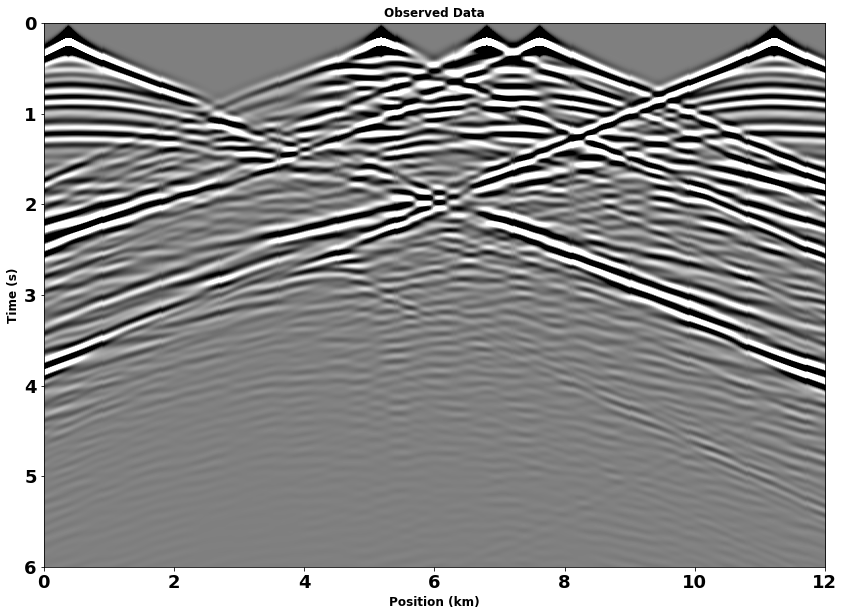

In [8]:
#plt.imshow(batch_rcv_amps_true[:,0,:].detach().cpu().numpy(),aspect='auto',cmap='gray')
#batch_rcv_amps_true[:,0,:].shape


%matplotlib inline 
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import matplotlib.pyplot as plt
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 10}
f, ax = plt.subplots(1, 1, figsize=(14, 10), sharey=False)
plt.rc('font', **font)

selected_shot = rcv_amps_true[:,0,:]
vmin, vmax = torch.quantile(selected_shot,
                            torch.tensor([0.05, 0.95]).to(device))

ax.imshow(selected_shot.cpu(), aspect='auto', cmap='gray',
             vmin=vmin, vmax=vmax,
             extent=[0, selected_shot.shape[1] * dx/1000, selected_shot.shape[0] *(0.003), 0])

ax.set_xlabel('Position (km)',fontsize='large', fontweight='bold')
ax.set_ylabel('Time (s)',fontsize='large', fontweight='bold')
ax.set_title('Observed Data',fontsize='large', fontweight='bold')
#ax.text(0, -0.15, 'a)', fontsize = 12) 
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
#ax.set_xticklabels([])
plt.show()
#f.savefig('Observed_Combined.png', bbox_inches='tight',transparent=True, dpi =100)


## Plotting the Reconstructed Velocity Model

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


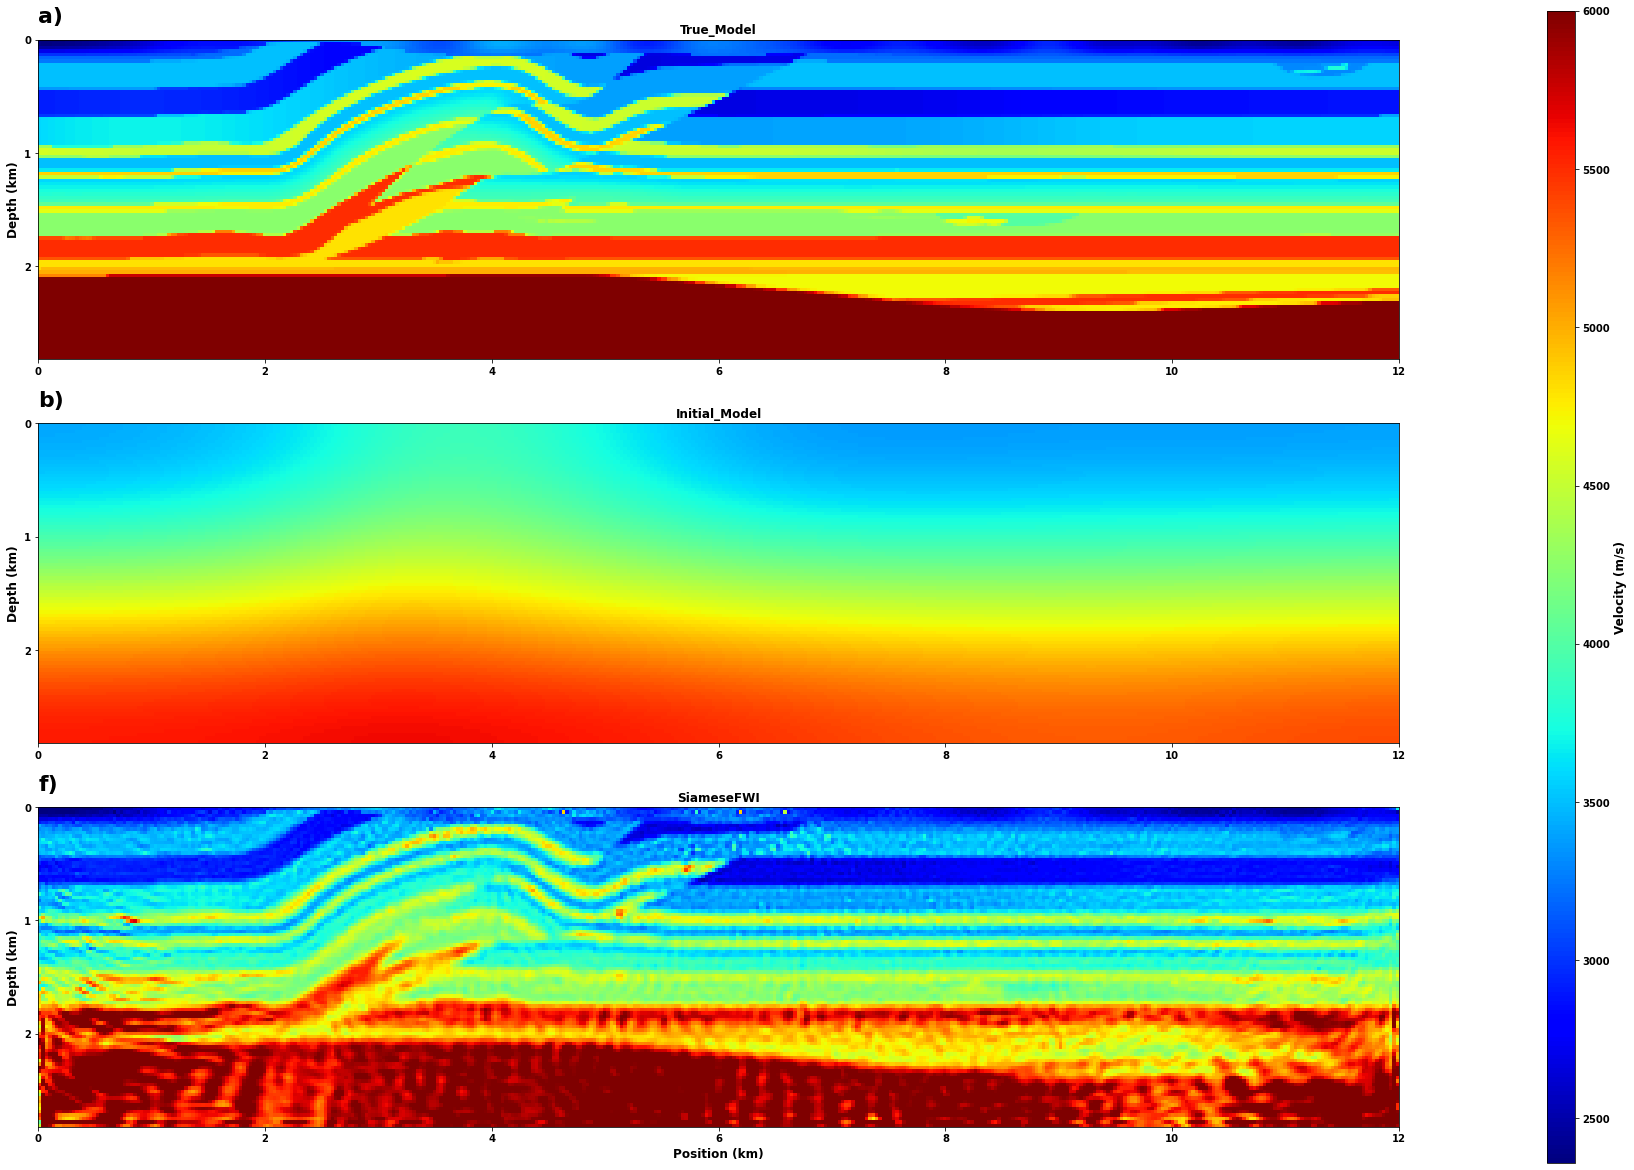

The reconstructed velocity model has SNR: 25.00886481403061 dB and SSIM: 0.6677244


In [9]:

f, ax = plt.subplots(3,1,figsize=(40, 20))
plt.rc('font', **font)

# True Model
modeltrue = model1
im = ax[0].imshow(modeltrue, cmap='jet', vmin=box_min, vmax=box_max, 
                extent=[0, modeltrue.shape[1] * dx / 1000, modeltrue.shape[0] * dx1 / 1000, 0])

#ax[0].set_xlabel('Position (km)',fontsize='large', fontweight='bold')
ax[0].set_ylabel('Depth (km)',fontsize='large', fontweight='bold')
ax[0].set_title('True_Model',fontsize='large', fontweight='bold')
ax[0].text(0, -0.15, 'a)', fontsize = 22) 
ax[0].xaxis.set_major_locator(MaxNLocator(integer=True))
ax[0].set_yticks(np.arange(y.min(), y.max(), 1)) 

# Initial Model
init_V = model_init
im = ax[1].imshow(init_V, cmap='jet', vmin=box_min, vmax=box_max, 
                extent=[0, init_V.shape[1] * dx / 1000, init_V.shape[0] * dx1 / 1000, 0])
#ax[1].set_xlabel('Position (km)',fontsize='large', fontweight='bold')
ax[1].set_ylabel('Depth (km)',fontsize='large', fontweight='bold')
ax[1].set_title('Initial_Model',fontsize='large', fontweight='bold')
ax[1].text(0, -0.15, 'b)', fontsize = 22) 
ax[1].xaxis.set_major_locator(MaxNLocator(integer=True))
ax[1].set_yticks(np.arange(y.min(), y.max(), 1)) 

# Siamese Model
Siamese_Vel = scipy.io.loadmat(fwi_result + 'SIAMESERec_.mat')
Siamese_Vel = Siamese_Vel['rec']
im = ax[2].imshow(Siamese_Vel, cmap='jet', vmin=box_min, vmax=box_max, 
                extent=[0, Siamese_Vel.shape[1] * dx / 1000, Siamese_Vel.shape[0] * dx1 / 1000, 0])
ax[2].set_xlabel('Position (km)',fontsize='large', fontweight='bold')
ax[2].set_ylabel('Depth (km)',fontsize='large', fontweight='bold')
ax[2].set_title('SiameseFWI',fontsize='large', fontweight='bold')
ax[2].text(0, -0.15, 'f)', fontsize = 22) 
ax[2].xaxis.set_major_locator(MaxNLocator(integer=True))
ax[2].set_yticks(np.arange(y.min(), y.max(), 1)) 


cbar_ax = f.add_axes([0.8, 0.1, 0.01, 0.8])
f.colorbar(im, fraction=0.005, pad=0.04,cax=cbar_ax)
cbar_ax.set_ylabel('Velocity (m/s)',fontsize='large', fontweight='bold')

plt.show()

snr = ComputeSNR(Siamese_Vel,  
          model_true.detach().cpu().numpy())

ssim = ComputeSSIM(Siamese_Vel, \
          model_true.detach().cpu().numpy())

print('The reconstructed velocity model has SNR:', str(snr), 'dB', 'and SSIM:',str(ssim.cpu().detach().cpu().numpy()))